# 04_train_MLFlow.ipynb

**Hyperparameter Tuning & Final Training with MLflow, Hyperopt & XGBoost**

This notebook demonstrates a streamlined in-notebook hyperparameter optimization workflow using Hyperopt and MLflow’s autologging. It:

1. **Configures MLflow** for experiment tracking and disables heavy environment inference.  
2. **Loads preprocessed train/validation/test splits** from S3.  
3. **Defines** a fixed parameter set plus a Hyperopt search space for `max_depth` and `eta`.  
4. **Runs** a lightweight sweep, printing RMSE for each trial and collecting results in a summary table.  
5. **Retrains** the final model on the full dataset using the best hyperparameters.  
6. **Evaluates** test-set performance (RMSE) and logs the final model artifact to MLflow.  

In [1]:
!pip install mlflow hyperopt

In [4]:
# 04_train.ipynb
# XGBoost training with Hyperparameter Tuning via MLflow & Hyperopt for KWH prediction

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import sagemaker
import mlflow
import mlflow.xgboost
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

import os
os.environ["MLFLOW_DISABLE_ENVIRONMENT_INFERENCE"] = "true"

# ── Set up MLflow experiment ────────────────────────────────────────────────
mlflow.set_experiment("recs_xgb_tuning")
# Turn on autologging for XGBoost but we will log models manually
mlflow.xgboost.autolog(log_models=False)

# ── Load data from S3 and prepare train/valid/test splits ─────────────────
sess   = sagemaker.Session()
bucket = sess.default_bucket()
prefix = "recs"

# Read Parquet splits
X_train = pd.read_parquet(f"s3://{bucket}/{prefix}/train/X_train.parquet")
X_test  = pd.read_parquet(f"s3://{bucket}/{prefix}/test/X_test.parquet")
y_train = pd.read_parquet(f"s3://{bucket}/{prefix}/train/y_train.parquet").squeeze()
y_test  = pd.read_parquet(f"s3://{bucket}/{prefix}/test/y_test.parquet").squeeze()

# Log-transform the training target
y_train = np.log1p(y_train)

# Split off a validation set
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Wrap in DMatrix
dtrain = xgb.DMatrix(X_tr,  label=y_tr)
dvalid = xgb.DMatrix(X_val, label=y_val)
dtest  = xgb.DMatrix(X_test, label=y_test)

# ── Define fixed params and hyperparameter search space ────────────────────
sample_idx = np.random.choice(X_tr.shape[0], 1000, replace=False)
dtrain_small = xgb.DMatrix(X_tr.iloc[sample_idx], label=y_tr.iloc[sample_idx])
dvalid_small = xgb.DMatrix(X_val.iloc[:200], label=y_val.iloc[:200])

fixed_params = {
    "objective": "reg:squarederror",
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "seed": 42
}

space = {
    "max_depth":    hp.choice("max_depth",    [4, 6, 8, 10]),
    "eta":          hp.loguniform("eta",     np.log(0.1), np.log(0.3)),
}

# ── Objective function for Hyperopt ────────────────────────────────────────
def objective(hparams):
    with mlflow.start_run(nested=True):
        # Merge fixed + current hparams
        params = {**fixed_params, 
                  "max_depth":    hparams["max_depth"],
                  "eta":          hparams["eta"]}
        mlflow.log_params(params)

        # Train with early stopping
        model = xgb.train(
            params,
            dtrain,
            num_boost_round=500,
            evals=[(dtrain_small, "train"), (dvalid_small, "valid")],
            early_stopping_rounds=25,
            verbose_eval=False
        )

        # Validate
        preds_val = model.predict(dvalid_small)
        preds_val = np.expm1(preds_val)
        y_val_orig = np.expm1(y_val[:200])
        rmse_val = mean_squared_error(y_val_orig, preds_val, squared=False)

        # Print out this trial’s result
        print(f"Trial {mlflow.active_run().info.run_id}: "
              f"max_depth={params['max_depth']}, "
              f"eta={params['eta']:.4f}, "
              f"→ rmse_val={rmse_val:.4f}")

        # Log metrics & model artifact
        mlflow.log_metric("rmse_val", rmse_val)
        # mlflow.xgboost.log_model(model, artifact_path="model")

        return {"loss": rmse_val, "status": STATUS_OK}

# ── Run the hyperparameter search ──────────────────────────────────────────
trials = Trials()
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=10,
    trials=trials
)

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

[04/23/25 10:53:13] INFO     build_posterior_wrapper took 0.001041 seconds                               ]8;id=764890;file:///opt/conda/lib/python3.12/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=480996;file:///opt/conda/lib/python3.12/site-packages/hyperopt/tpe.py#864\864]8;;\

                    INFO     TPE using 0 trials                                                          ]8;id=315255;file:///opt/conda/lib/python3.12/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=758584;file:///opt/conda/lib/python3.12/site-packages/hyperopt/tpe.py#900\900]8;;\

Trial 96cfbc9badbc4b129a082af5a3ab10c3: max_depth=6, eta=0.1151, → rmse_val=3162.6047
 10%|█         | 1/10 [00:27<04:11, 27.92s/trial, best loss: 3162.6047354851576]

/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[04/23/25 10:53:41] INFO     build_posterior_wrapper took 0.001133 seconds                               ]8;id=579904;file:///opt/conda/lib/python3.12/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=872478;file:///opt/conda/lib/python3.12/site-packages/hyperopt/tpe.py#864\864]8;;\

                    INFO     TPE using 1/1 trials with best loss 3162.604735                             ]8;id=874100;file:///opt/conda/lib/python3.12/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=492050;file:///opt/conda/lib/python3.12/site-packages/hyperopt/tpe.py#900\900]8;;\

Trial 9705736bf5f248c6944b4779e8fd1e4b: max_depth=10, eta=0.2097, → rmse_val=3051.0635
 20%|██        | 2/10 [00:50<03:18, 24.79s/trial, best loss: 3051.0635107732824]

/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[04/23/25 10:54:04] INFO     build_posterior_wrapper took 0.001042 seconds                               ]8;id=680264;file:///opt/conda/lib/python3.12/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=914909;file:///opt/conda/lib/python3.12/site-packages/hyperopt/tpe.py#864\864]8;;\

                    INFO     TPE using 2/2 trials with best loss 3051.063511                             ]8;id=384763;file:///opt/conda/lib/python3.12/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=855467;file:///opt/conda/lib/python3.12/site-packages/hyperopt/tpe.py#900\900]8;;\

Trial 1bf2d1d164ed4143be2e84c04cfa3d8c: max_depth=10, eta=0.2459, → rmse_val=3199.4327
 30%|███       | 3/10 [01:43<04:22, 37.46s/trial, best loss: 3051.0635107732824]

/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[04/23/25 10:54:56] INFO     build_posterior_wrapper took 0.001038 seconds                               ]8;id=684182;file:///opt/conda/lib/python3.12/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=947679;file:///opt/conda/lib/python3.12/site-packages/hyperopt/tpe.py#864\864]8;;\

                    INFO     TPE using 3/3 trials with best loss 3051.063511                             ]8;id=74113;file:///opt/conda/lib/python3.12/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=283269;file:///opt/conda/lib/python3.12/site-packages/hyperopt/tpe.py#900\900]8;;\

Trial 5dde01c687094303ab3fe60ef5751d62: max_depth=4, eta=0.2728, → rmse_val=3852.0277
 40%|████      | 4/10 [01:58<02:53, 28.94s/trial, best loss: 3051.0635107732824]

/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[04/23/25 10:55:12] INFO     build_posterior_wrapper took 0.001110 seconds                               ]8;id=534133;file:///opt/conda/lib/python3.12/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=106059;file:///opt/conda/lib/python3.12/site-packages/hyperopt/tpe.py#864\864]8;;\

                    INFO     TPE using 4/4 trials with best loss 3051.063511                             ]8;id=80223;file:///opt/conda/lib/python3.12/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=963043;file:///opt/conda/lib/python3.12/site-packages/hyperopt/tpe.py#900\900]8;;\

Trial 9adf3a1f5dd84adcb029c52bf349fda1: max_depth=6, eta=0.1197, → rmse_val=3387.7956
 50%|█████     | 5/10 [02:36<02:39, 31.94s/trial, best loss: 3051.0635107732824]

/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[04/23/25 10:55:49] INFO     build_posterior_wrapper took 0.001097 seconds                               ]8;id=331627;file:///opt/conda/lib/python3.12/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=313841;file:///opt/conda/lib/python3.12/site-packages/hyperopt/tpe.py#864\864]8;;\

                    INFO     TPE using 5/5 trials with best loss 3051.063511                             ]8;id=858637;file:///opt/conda/lib/python3.12/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=182589;file:///opt/conda/lib/python3.12/site-packages/hyperopt/tpe.py#900\900]8;;\

Trial 9edea9d94cdd408e9b212f2d04a5ffda: max_depth=4, eta=0.2414, → rmse_val=3330.8729
 60%|██████    | 6/10 [02:56<01:51, 27.91s/trial, best loss: 3051.0635107732824]

/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[04/23/25 10:56:09] INFO     build_posterior_wrapper took 0.001088 seconds                               ]8;id=49299;file:///opt/conda/lib/python3.12/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=332307;file:///opt/conda/lib/python3.12/site-packages/hyperopt/tpe.py#864\864]8;;\

                    INFO     TPE using 6/6 trials with best loss 3051.063511                             ]8;id=246961;file:///opt/conda/lib/python3.12/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=514560;file:///opt/conda/lib/python3.12/site-packages/hyperopt/tpe.py#900\900]8;;\

Trial 2c8b55b2ce2646cbb4bffa0f9bc0e760: max_depth=10, eta=0.2557, → rmse_val=3179.6359
 70%|███████   | 7/10 [03:29<01:28, 29.56s/trial, best loss: 3051.0635107732824]

/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[04/23/25 10:56:42] INFO     build_posterior_wrapper took 0.001028 seconds                               ]8;id=71078;file:///opt/conda/lib/python3.12/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=347464;file:///opt/conda/lib/python3.12/site-packages/hyperopt/tpe.py#864\864]8;;\

                    INFO     TPE using 7/7 trials with best loss 3051.063511                             ]8;id=32119;file:///opt/conda/lib/python3.12/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=821358;file:///opt/conda/lib/python3.12/site-packages/hyperopt/tpe.py#900\900]8;;\

Trial 0c494eb668064bbfb196647d0d8b01bf: max_depth=6, eta=0.1242, → rmse_val=3564.0782
 80%|████████  | 8/10 [03:57<00:58, 29.12s/trial, best loss: 3051.0635107732824]

/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[04/23/25 10:57:10] INFO     build_posterior_wrapper took 0.001234 seconds                               ]8;id=821931;file:///opt/conda/lib/python3.12/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=748073;file:///opt/conda/lib/python3.12/site-packages/hyperopt/tpe.py#864\864]8;;\

                    INFO     TPE using 8/8 trials with best loss 3051.063511                             ]8;id=908130;file:///opt/conda/lib/python3.12/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=30777;file:///opt/conda/lib/python3.12/site-packages/hyperopt/tpe.py#900\900]8;;\

Trial 96d8541ec19449e4ba66981e151de87f: max_depth=8, eta=0.2001, → rmse_val=3378.8378
 90%|█████████ | 9/10 [04:14<00:25, 25.38s/trial, best loss: 3051.0635107732824]

/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[04/23/25 10:57:28] INFO     build_posterior_wrapper took 0.001318 seconds                               ]8;id=566916;file:///opt/conda/lib/python3.12/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=220328;file:///opt/conda/lib/python3.12/site-packages/hyperopt/tpe.py#864\864]8;;\

                    INFO     TPE using 9/9 trials with best loss 3051.063511                             ]8;id=767756;file:///opt/conda/lib/python3.12/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=677590;file:///opt/conda/lib/python3.12/site-packages/hyperopt/tpe.py#900\900]8;;\

Trial c63084d1b7a348d880c84fc6f3a48ebc: max_depth=10, eta=0.1166, → rmse_val=3428.0175
100%|██████████| 10/10 [04:59<00:00, 29.92s/trial, best loss: 3051.0635107732824]


/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



In [5]:
import pandas as pd

# map those same lists you used in the search
depths = [4, 6, 8, 10]

records = []
for t in trials.trials:
    vals = t["result"]
    loss = vals["loss"]
    # Hyperopt stores the sampled indices/values under t["misc"]["vals"]
    v = t["misc"]["vals"]
    record = {
        "max_depth":  depths[v["max_depth"][0]],
        "eta":        v["eta"][0],
        "rmse_val":   loss
    }
    records.append(record)

results_df = pd.DataFrame(records)
results_df = results_df.sort_values("rmse_val").reset_index(drop=True)

print("\nAll trials sorted by validation RMSE:")
print(results_df)


All trials sorted by validation RMSE:
   max_depth       eta     rmse_val
0         10  0.209678  3051.063511
1          6  0.115076  3162.604735
2         10  0.255668  3179.635913
3         10  0.245927  3199.432691
4          4  0.241384  3330.872887
5          8  0.200056  3378.837771
6          6  0.119738  3387.795618
7         10  0.116585  3428.017500
8          6  0.124202  3564.078154
9          4  0.272798  3852.027719


In [7]:
# Map choice indices back to values
depths    = [4, 6, 8, 10]
best_params = {
    **fixed_params,
    "max_depth":   depths[best["max_depth"]],
    "eta":         best["eta"]
}

print("🔎 Best hyperparameters:", best_params)

🔎 Best hyperparameters: {'objective': 'reg:squarederror', 'subsample': 0.8, 'colsample_bytree': 0.8, 'seed': 42, 'max_depth': 10, 'eta': 0.20967759776962158}


In [8]:
# Train final model with best hyperparameters & evaluate on test ───────
with mlflow.start_run(run_name="final_model"):
    mlflow.log_params(best_params)

    final_model = xgb.train(
        best_params,
        dtrain,
        num_boost_round=500,
        evals=[(dtrain, "train"), (dvalid, "valid")],
        early_stopping_rounds=25,
        verbose_eval=50
    )

    # Test-set predictions
    preds_test = final_model.predict(dtest)
    preds_test = np.expm1(preds_test)  # invert log
    rmse_test = mean_squared_error(y_test, preds_test, squared=False)

    mlflow.log_metric("rmse_test", rmse_test)
    mlflow.xgboost.log_model(final_model, artifact_path="model_final")

    print(f"✅ Final RMSE on test set: {rmse_test:.2f}")

[0]	train-rmse:0.57156	valid-rmse:0.59980
[50]	train-rmse:0.02493	valid-rmse:0.17517
[100]	train-rmse:0.00903	valid-rmse:0.17444
[126]	train-rmse:0.00524	valid-rmse:0.17445


/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:00:27] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1742444421431/work/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/04/23 11:00:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Final RMSE on test set: 2114.96


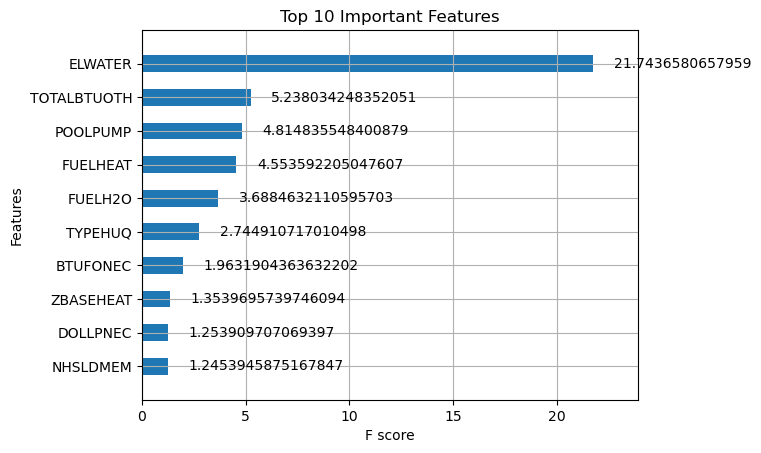

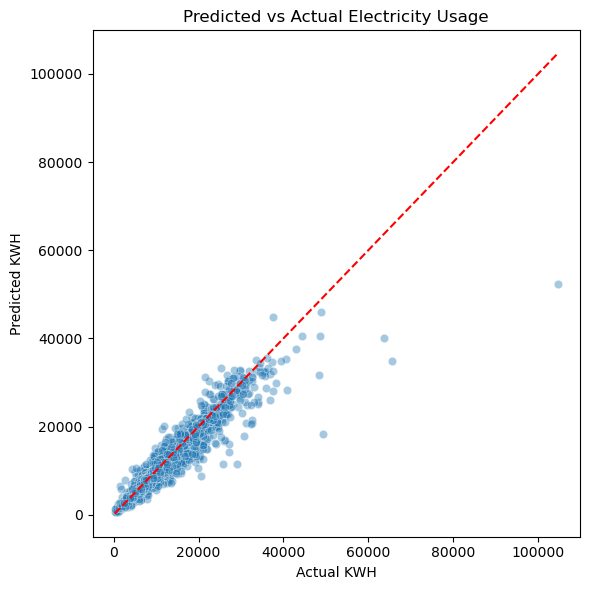

In [11]:
# Plot feature importance
import matplotlib.pyplot as plt
import seaborn as sns

xgb.plot_importance(final_model, max_num_features=10, importance_type='gain', height=0.5)
plt.title("Top 10 Important Features")
plt.show()

# 7. Plot predicted vs actual
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=preds_test, alpha=0.4)
plt.xlabel("Actual KWH")
plt.ylabel("Predicted KWH")
plt.title("Predicted vs Actual Electricity Usage")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.tight_layout()
plt.show()

In [12]:
%pip install shap

  Using cached shap-0.47.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (25 kB)
  Using cached slicer-0.0.8-py3-none-any.whl.metadata (4.0 kB)
Using cached shap-0.47.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.0 MB)
Using cached slicer-0.0.8-py3-none-any.whl (15 kB)
Note: you may need to restart the kernel to use updated packages.


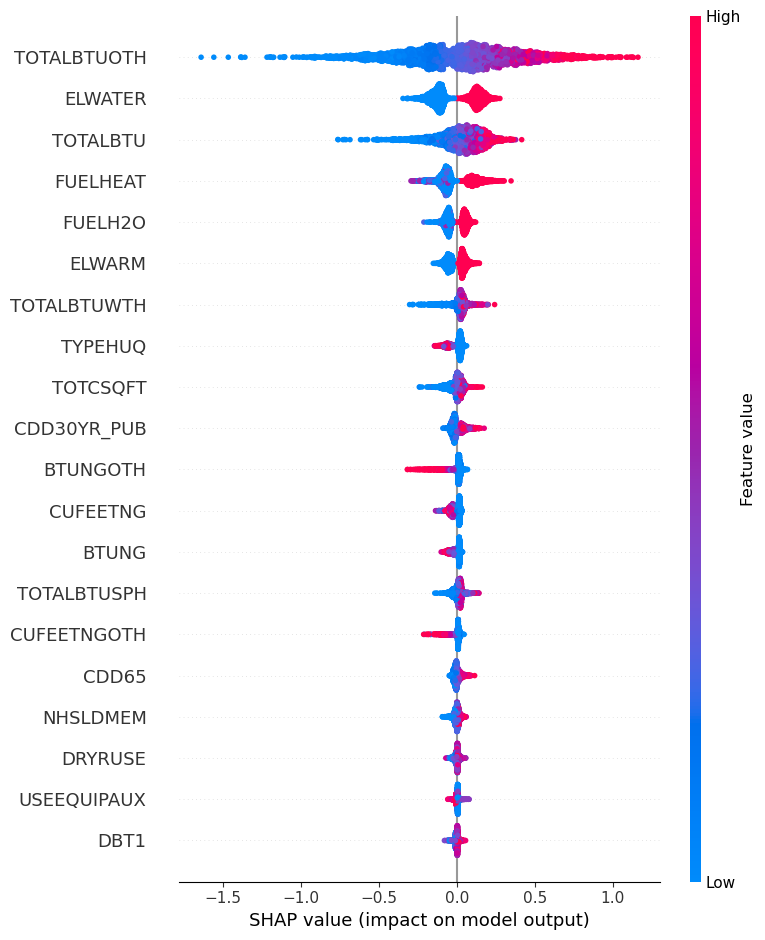

In [15]:
import shap

explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(dtest)
shap.summary_plot(shap_values, X_test)

In [19]:
# Save the trained Booster locally
final_model.save_model("model.bst")

# Package into a tar.gz
import tarfile

with tarfile.open("model.tar.gz", "w:gz") as tar:
    tar.add("model.bst", arcname="model.bst")

# Upload the tarball to S3
sess.upload_data(
    path="model.tar.gz",
    bucket=bucket,
    key_prefix="recs/output"    # writes to s3://{bucket}/recs/output/model.tar.gz
)

print(f"✅ Model packaged at s3://{bucket}/recs/output/model.tar.gz")

/opt/conda/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:32:02] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1742444421431/work/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


✅ Model packaged at s3://sagemaker-us-east-1-039774476556/recs/output/model.tar.gz
